In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [3]:
df = pd.read_csv("ecommerceDataset.csv", header=None)
print(np.sum(df[1].isna()))
df = df.dropna()
print(np.sum(df[1].isna()))
df.head()

1
0


,0,1
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


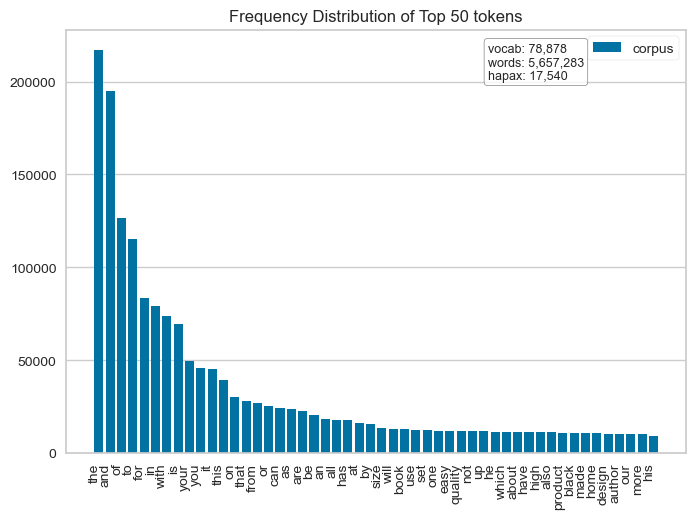

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [4]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df[1])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [6]:
text = df[1]
labels = df[0]

print(text.shape, labels.shape)

(50424,) (50424,)


In [9]:
# remove digits, @-mentions, links, stopwords
text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in nltk.corpus.stopwords.words()]))

text.shape

(50424,)

In [10]:
import pickle
with open("text.pkl", "wb") as f:
  pickle.dump(text, f)
with open("labels.pkl", "wb") as f:
  pickle.dump(labels, f)

In [2]:
import pickle
with open("text.pkl", "rb") as f:
  text = pickle.load(f)
with open("labels.pkl", "rb") as f:
  labels = pickle.load(f)

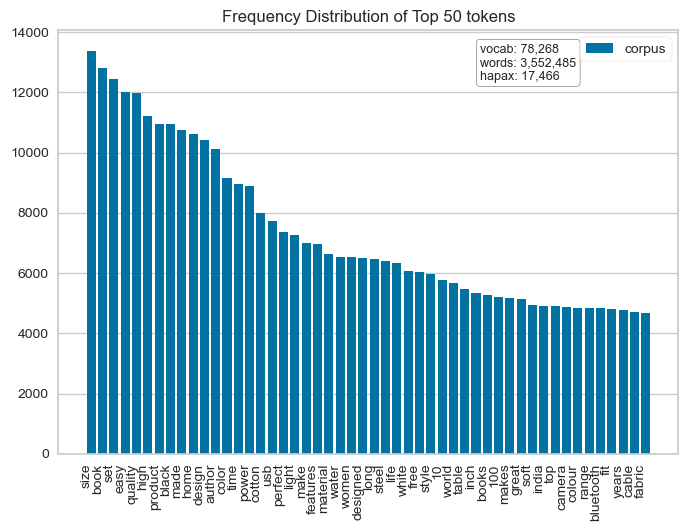

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [12]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
text = np.array(text)
labels = np.array(labels)

In [5]:
labels = np.array(labels)
text = np.array(text)
text = text[(labels == "Books") | (labels == "Electronics")]
labels = labels[(labels == "Books") | (labels == "Electronics")]

In [6]:
lengths = []

X = text
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [8]:
lengths = np.array(lengths)
X = np.array(X)

print(lengths)
print(lengths.shape)
print(np.sum(lengths < 64) / len(lengths))
print(np.sum(lengths < 64))
print(np.sum((lengths < 64) & (labels == "Electronics")))
print(np.sum((lengths < 64) & (labels == "Books")))

[177   6 110 ... 259 302  10]
(22441,)
0.38572256138318256
8656
2988
5668


In [9]:
X_electronics = X[(lengths < 64) & (labels == "Electronics")].tolist()
X_books = X[(lengths < 64) & (labels == "Books")].tolist()
X = X_electronics[:2000] + X_books[:2000]

y_electronics = labels[(lengths < 64) & (labels == "Electronics")].tolist()
y_books = labels[(lengths < 64) & (labels == "Books")].tolist()
y = y_electronics[:2000] + y_books[:2000]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [17]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [18]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.4738, -0.2803, -0.2252,  ..., -0.5440,  0.7136, -0.0855],
         [-0.2412,  0.0156, -0.2115,  ..., -0.5430,  0.6179,  0.2402],
         [-0.5992, -0.0850, -0.2734,  ..., -0.4937,  0.5401,  0.5064],
         ...,
         [-0.5111, -0.3645,  0.0510,  ..., -0.6311,  0.8011, -0.1296],
         [-0.5129, -0.3624,  0.0516,  ..., -0.6312,  0.8099, -0.1211],
         [-0.4881, -0.3325,  0.0279,  ..., -0.6259,  0.7941, -0.1357]],

        [[-0.0022,  0.2914,  0.4024,  ..., -0.6488,  0.2842, -0.3522],
         [-0.2651,  0.4191,  0.0921,  ..., -0.3796,  0.0959,  0.4956],
         [-0.2921,  0.4739,  0.3472,  ..., -0.3151,  0.0612,  0.4433],
         ...,
         [ 0.1515,  0.2160,  1.0116,  ..., -1.1728,  0.1021, -0.2934],
         [ 0.1456,  0.2188,  1.0071,  ..., -1.1430,  0.1049, -0.3202],
         [ 0.1833,  0.2290,  0.9217,  ..., -1.1237,  0.0693, -0.3868]],

        [[ 0.0341, -0.1188, -0.1810,  ..., -0.2926,  

In [19]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [20]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.3392,  0.0082, -0.0236,  ..., -0.3429,  0.6787, -0.2827],
         [-0.5256,  0.4869,  0.4904,  ..., -0.3767,  0.3419,  0.0778],
         [-0.5341,  0.4564,  0.5262,  ..., -0.3731,  0.3106,  0.0787],
         ...,
         [-0.2781, -0.2088, -0.0121,  ..., -0.2838,  0.7018, -0.3053],
         [-0.2765, -0.2045, -0.0199,  ..., -0.2775,  0.7076, -0.2964],
         [-0.2570, -0.1914, -0.0533,  ..., -0.2828,  0.6929, -0.3131]],

        [[-0.1938, -0.6163,  0.5778,  ..., -0.2210,  0.3561, -0.2537],
         [ 0.2272, -0.8323,  0.9139,  ..., -0.5257,  0.4330, -0.5681],
         [-0.2697, -1.0299,  0.8708,  ..., -0.2946,  0.0919, -0.9850],
         ...,
         [-0.2211, -0.8732,  1.0080,  ..., -0.8736,  0.7101, -0.4938],
         [-0.2457, -0.8787,  1.0332,  ..., -0.8791,  0.7048, -0.6042],
         [-0.2638, -0.8810,  0.9036,  ..., -0.8232,  0.7246, -0.6567]],

        [[-0.1966, -0.2700, -0.0194,  ...,  0.0301,  

In [21]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [22]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPClassifier()

In [23]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == y_train))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == y_test))

Train accuracy: 0.982
Test accuracy: 0.88


In [24]:
print(np.unique(y_test))

['Books' 'Electronics']


In [25]:
np.mean(y_test=="Electronics")

0.4